# Cross Validation and Hyper-Tuning

The objective of this tutorial is to familiarize ourselves with hyperparameter tuning of neural networks using cross validation. We will consider a very simple function to learn:

$$u(x) = 10 sin(4x)+6, \quad x\in(0, 2\pi)$$

The goal of hyperparameter tuning is to find hyperparameters that minimize the generalization error (an idealized metric which we never have access to). In order to select hyper-parameters that (hopefully) minimize this error, we resort to the classical (train, validation, test) split. In this tutorial we will use different splits, evaluating our approach with the so-called K-Fold cross validation scheme.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import KFold
mpl.rcParams['figure.dpi']= 300

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Define the exact solution
def exact_solution(x):
    return 10 * torch.sin(4*x) + 6

$\mathbf{\text{Step 1: Dataset Generation}}$

We are going to use the training set 

$$S=\{ (x_i, u_i), ~i=1,...,n \}$$ 

with 

$$x_i \sim U\big(0, 2\pi\big), \quad u_i \sim N\big(10 sin(4x_i)+6, \sigma\big).$$

Here, $U(a,b)$ is a uniform random distribution between $a$ and $b$, and $N(\mu, \sigma)$ is a normal distribution with mean $\mu$ and standard deviation $\sigma$

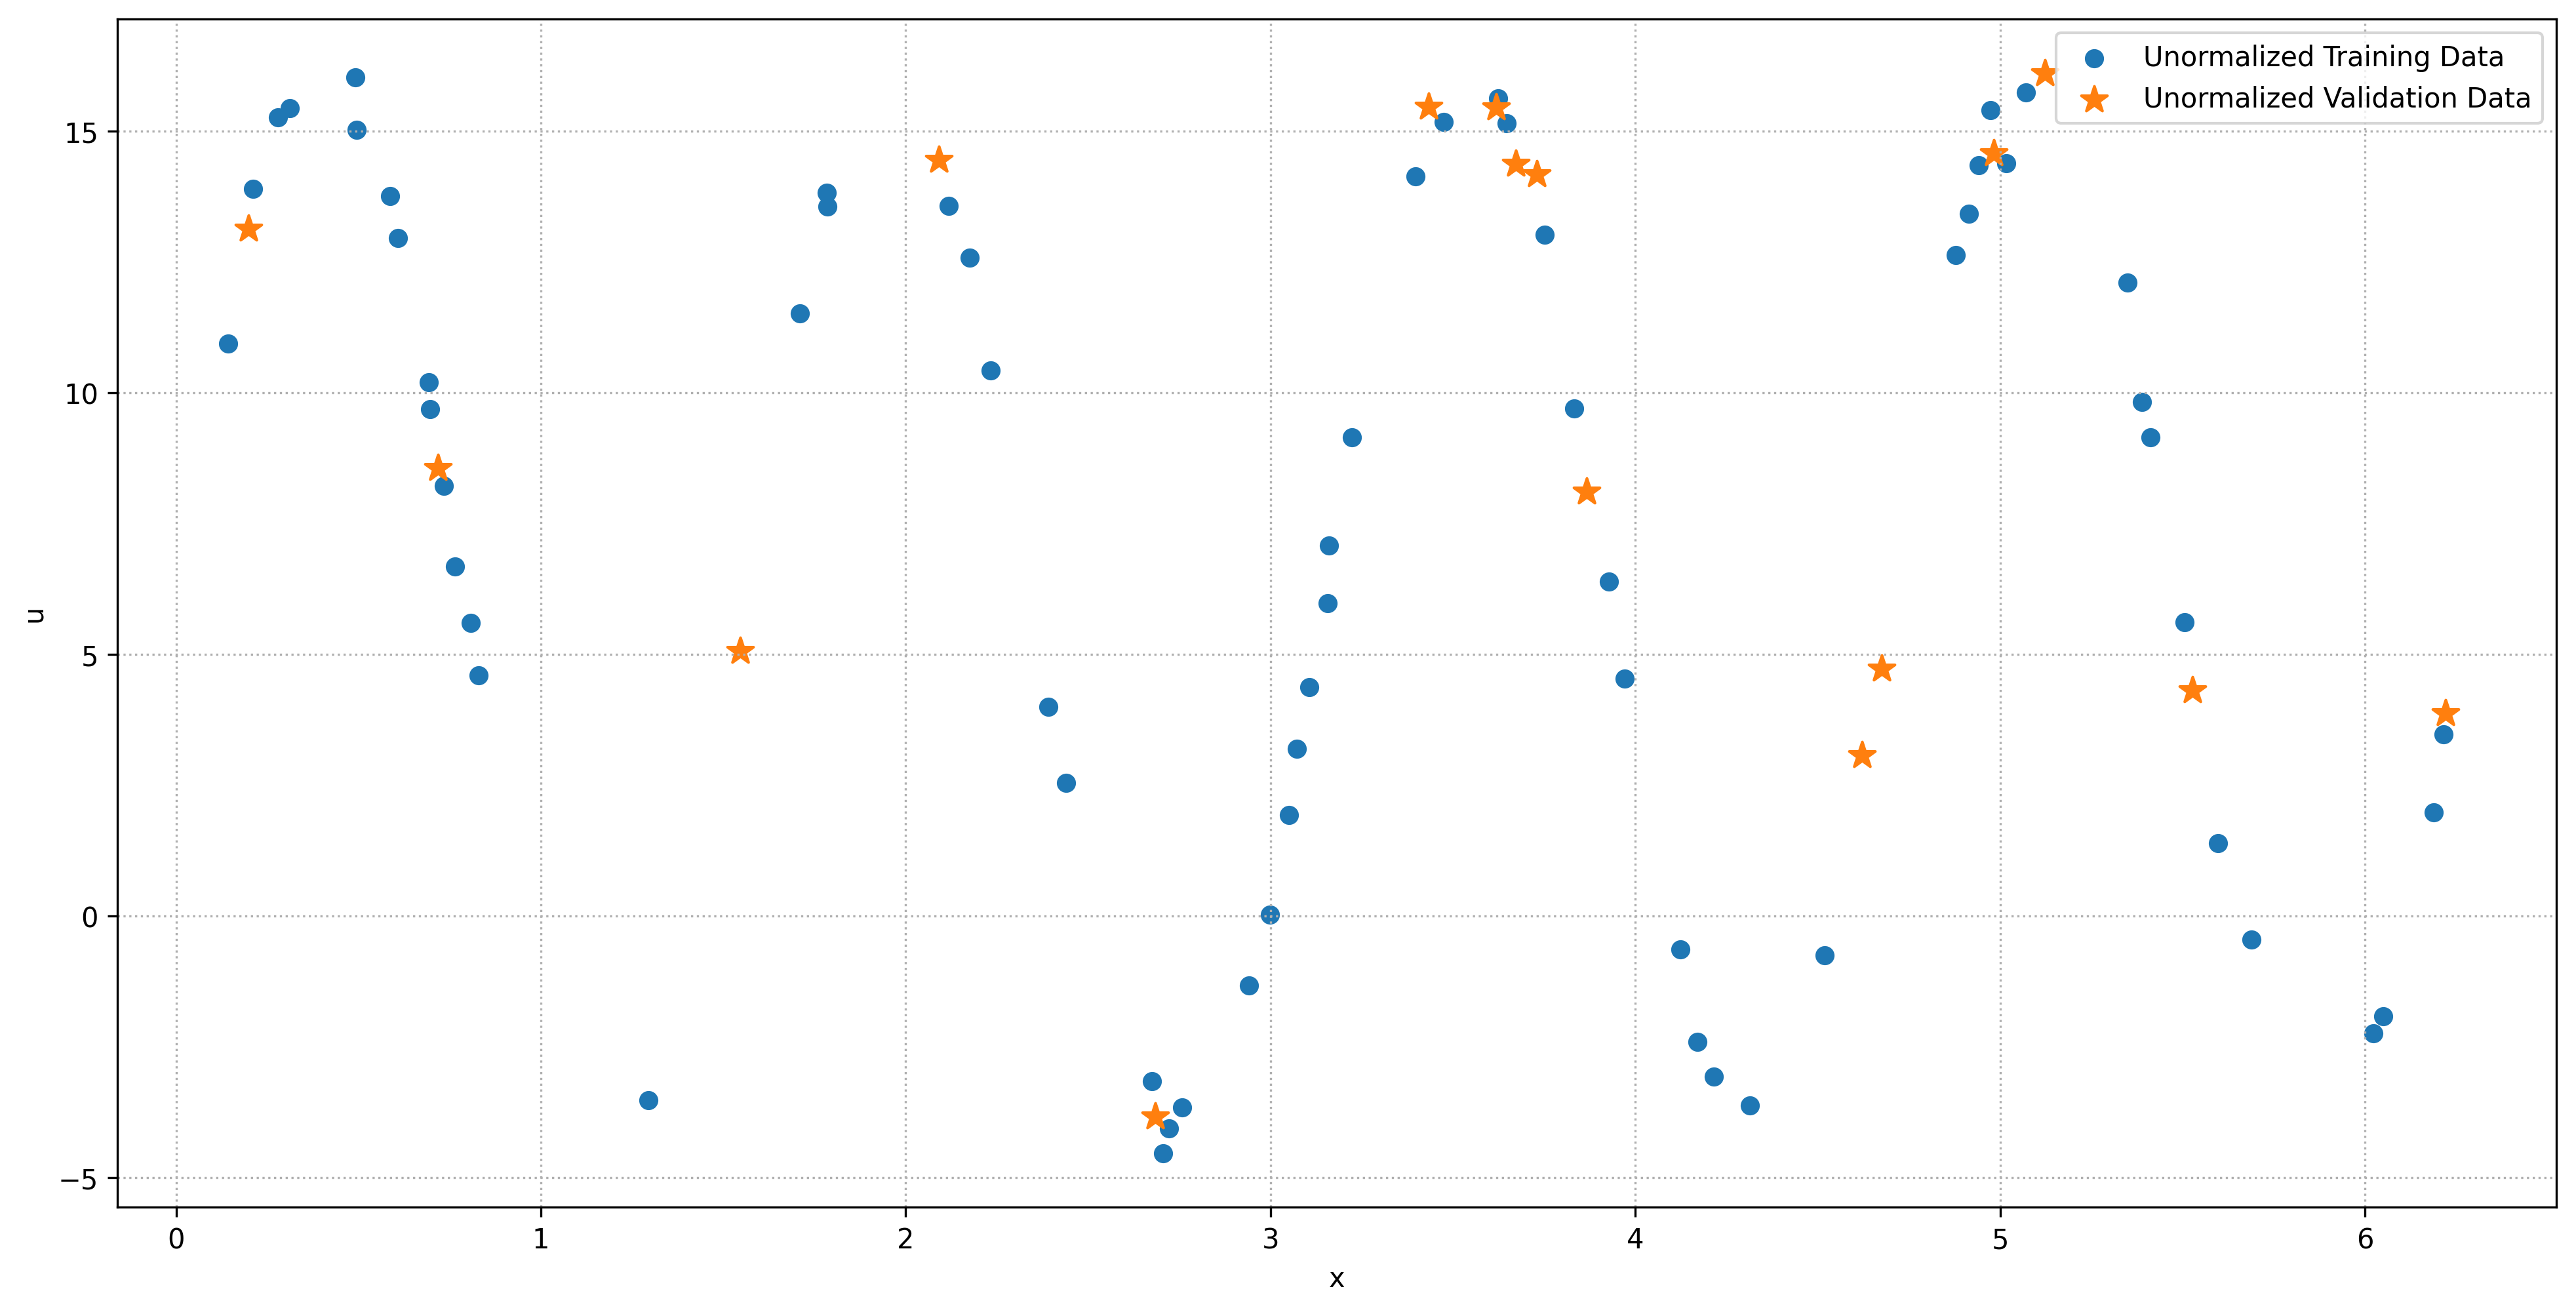

In [ ]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"
# Random Seed for dataset generation
sampling_seed = 84
torch.manual_seed(sampling_seed)

# Number of training samples
n_samples = 80
# Noise level
sigma = .4

x = 2*np.pi*torch.rand((n_samples, 1))
y = exact_solution(x) + sigma*torch.randn(x.shape)


validation_size = int(20*x.shape[0]/100)
training_size = x.shape[0] - validation_size
x_train = x[:training_size,:]
y_train = y[:training_size,:]

# normalizing the data
x_train_mean, x_train_std = x_train.mean(), x_train.std()
y_train_mean, y_train_std = y_train.mean(), y_train.std()

def normalize_y_with_training_stats(y):
  return (y - y_train_mean) / y_train_std

def denormalize_y_with_training_stats(y):
  return y * y_train_std + y_train_mean

def normalize_x_with_training_stats(x):
  return (x - x_train_mean) / x_train_std

def denormalize_x_with_training_stats(x):
  return x * x_train_std + x_train_mean

x_train_normalized = normalize_x_with_training_stats(x_train)
y_train_normalized = normalize_y_with_training_stats(y_train)

x_val = x[training_size:,:]
y_val = y[training_size:,:]

x_val_normalized = normalize_x_with_training_stats(x_val)
y_val_normalized = normalize_y_with_training_stats(y_val)

batch_size = n_samples
# feed in NORMALIZED y training data, x is okay
training_set = DataLoader(
    torch.utils.data.TensorDataset(x_train_normalized, y_train_normalized),
    batch_size=batch_size, shuffle=True)

plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.scatter(x_train,y_train, label="Unormalized Training Data")
plt.scatter(x_val,y_val, marker="*", s=100, label="Unormalized Validation Data")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

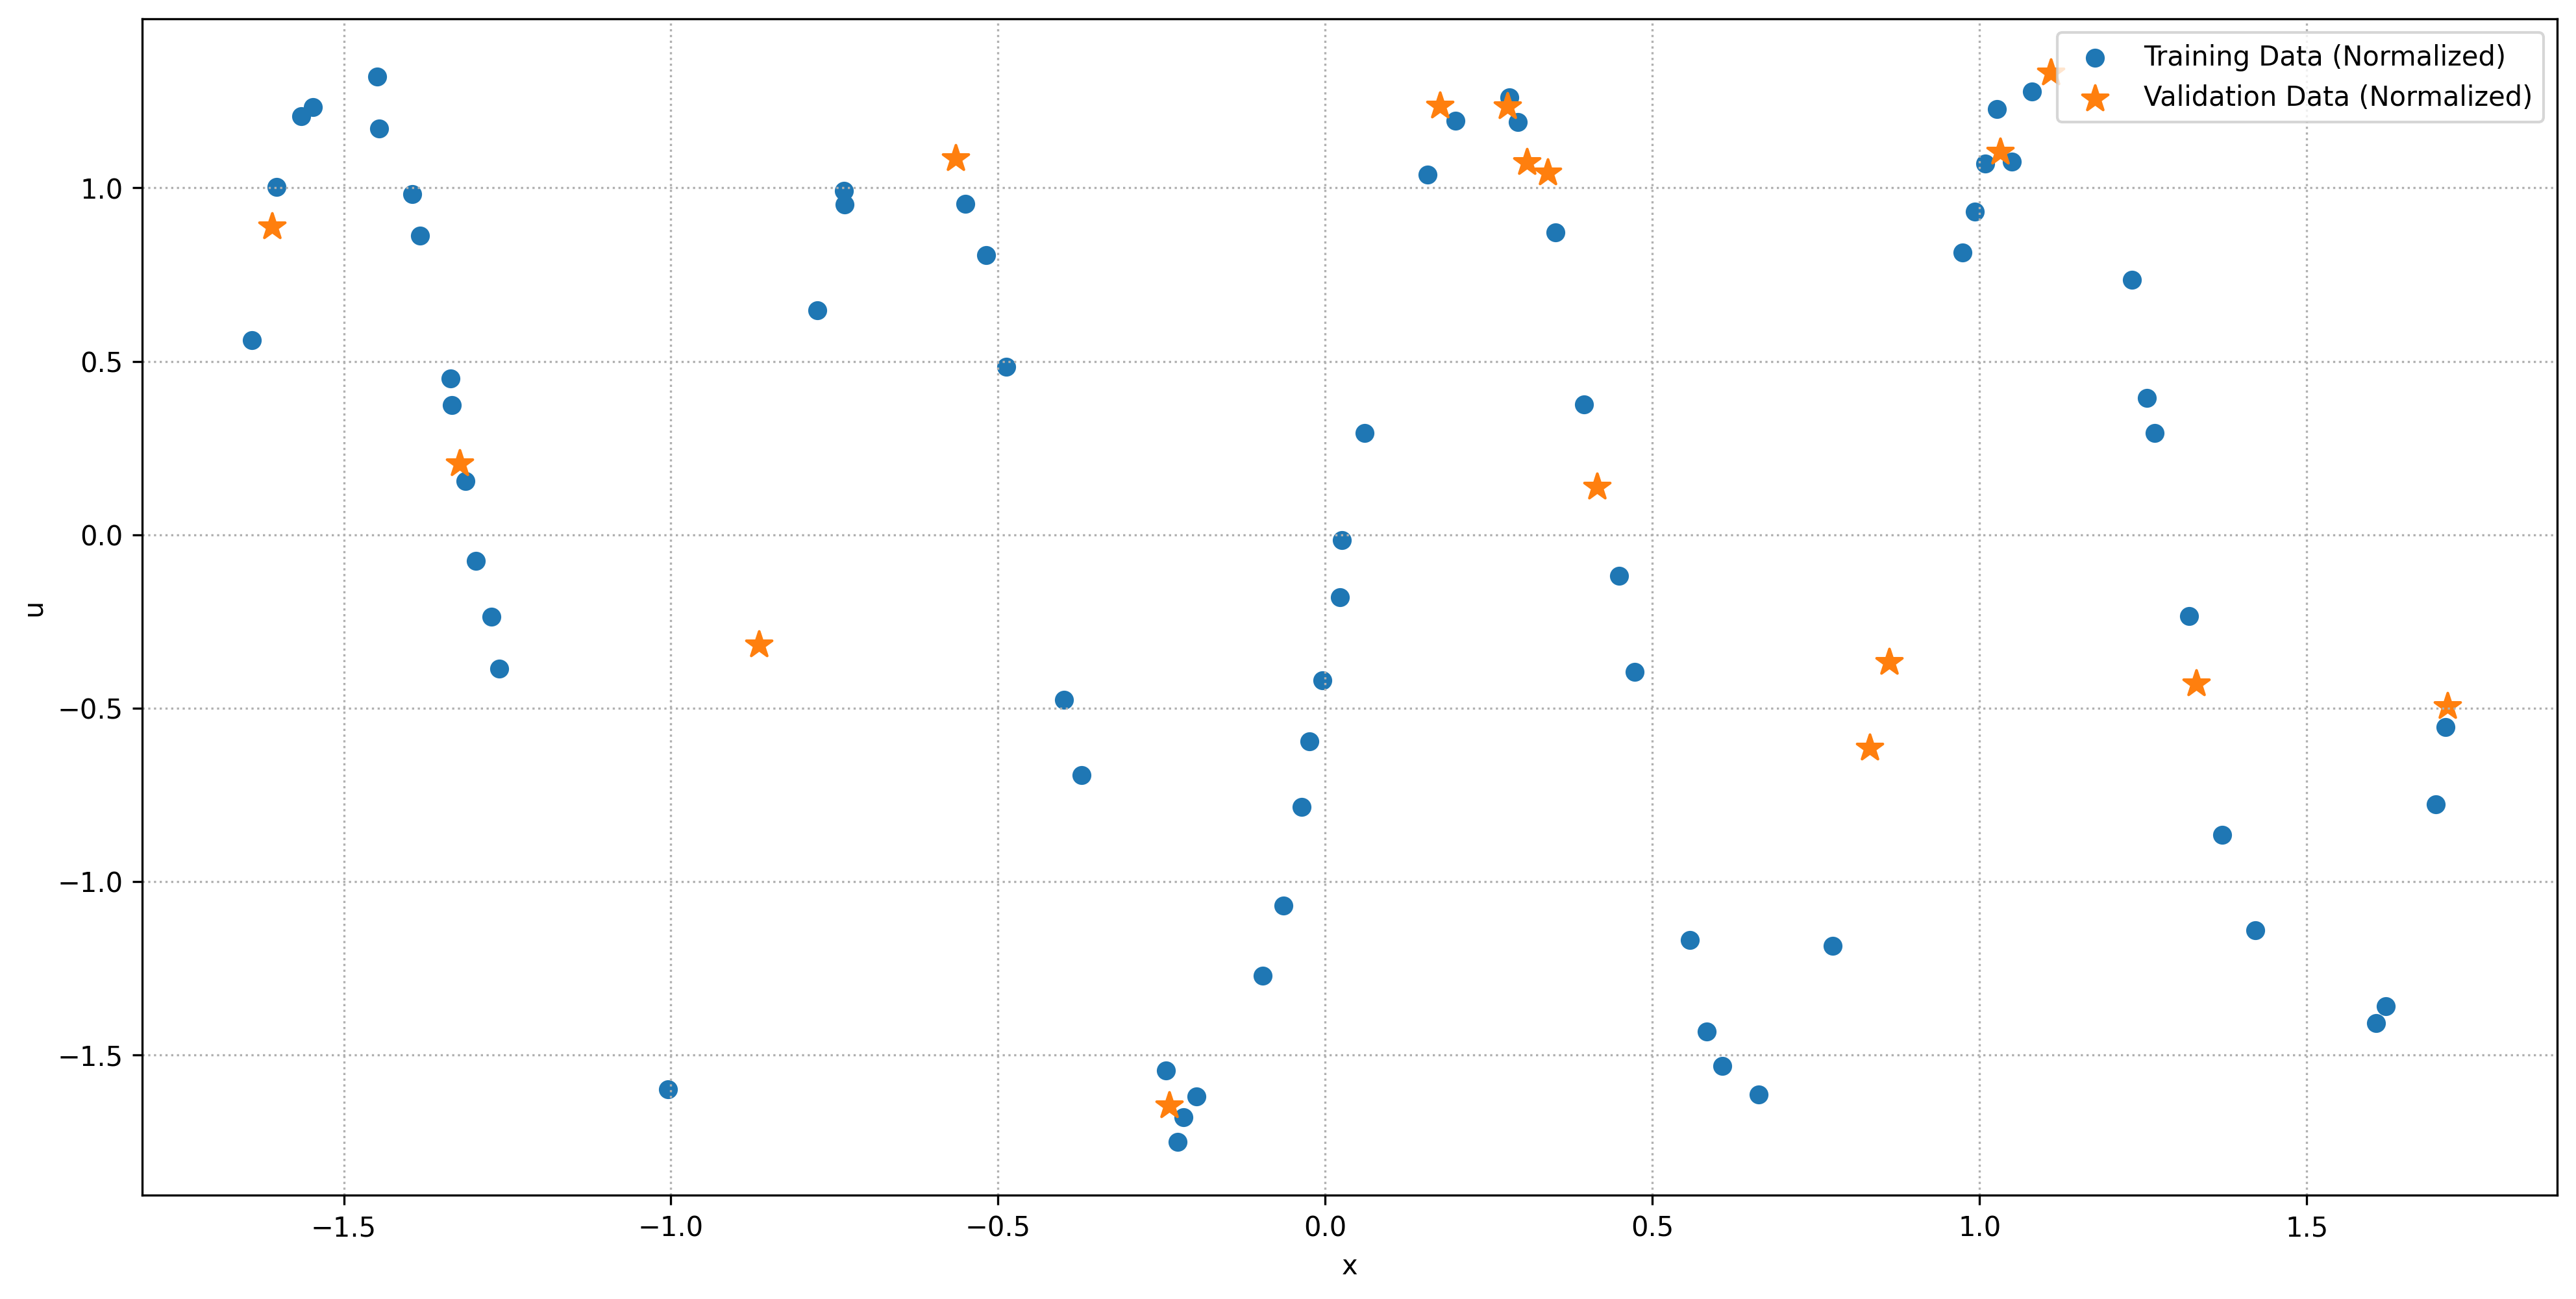

In [ ]:
plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.scatter(x_train_normalized,y_train_normalized, label="Training Data (Normalized)")
plt.scatter(x_val_normalized,y_val_normalized, marker="*", s=100, label="Validation Data (Normalized)")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

$\mathbf{\text{Step 2: Model Generation}}$

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(self.neurons, self.neurons)
             for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

In [ ]:
# Model definition
# my_network = NeuralNet(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)
my_network = NeuralNet_Seq(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=5, neurons=12)

In [ ]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)

$\mathbf{\text{Step 3: Model Training}}$

In [ ]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.002, weight_decay=0)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [ ]:
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()/ len(training_set)
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, ))**p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)
        
        if verbose:
            print('Training Loss: ', np.round(running_loss[0],8))
            print('Validation Loss: ', np.round(validation_loss,8))
            
    print('Final Training Loss: ', np.round(history[0][-1],8))
    print('Final Validation Loss: ', np.round(history[1][-1],8))
    return history


In [ ]:
n_epochs = 3000
history = fit(my_network, training_set, x_val_normalized, y_val_normalized, n_epochs, optimizer_, p=2, verbose=False )

Final Training Loss:  0.0014333
Final Validation Loss:  0.03304314


$\mathbf{\text{Step 3: Model Evaluation}}$

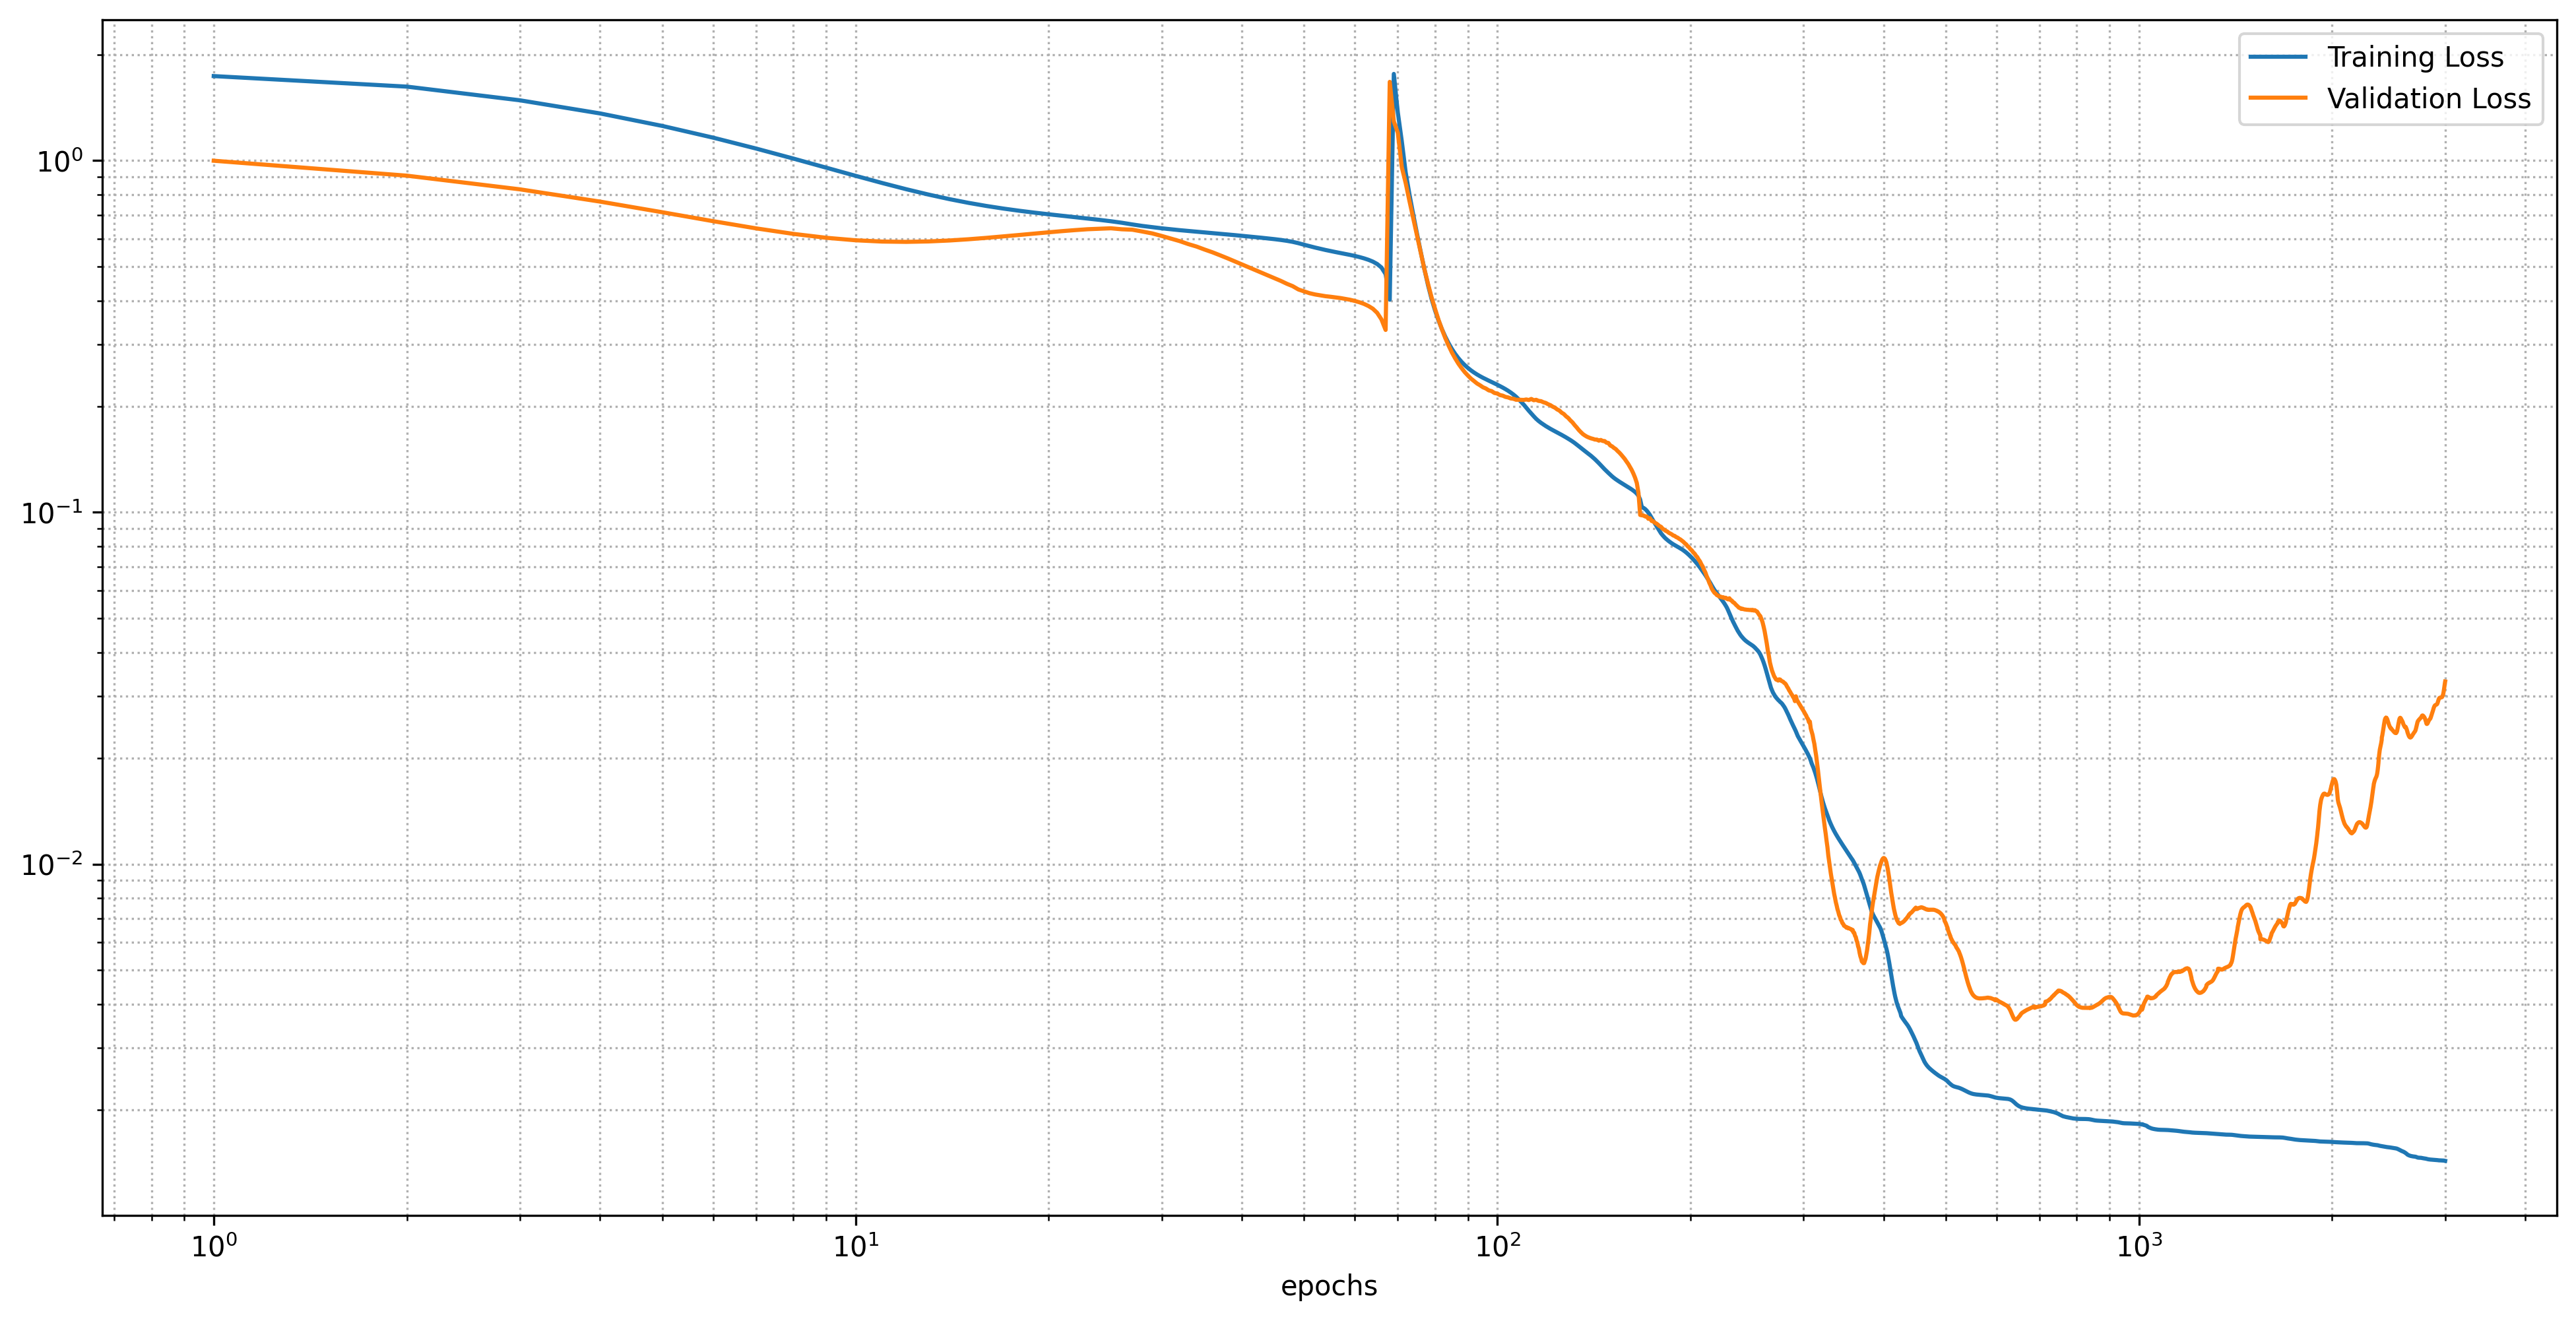

In [ ]:
plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), history[0], label="Training Loss")
plt.plot(np.arange(1,n_epochs+1), history[1], label="Validation Loss")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epochs")
plt.legend()

In [ ]:
x_test = torch.linspace(0, 2*np.pi, 10000).reshape(-1,1)
y_test = exact_solution(x_test).reshape(-1,)
x_test_normalized = normalize_x_with_training_stats(x_test)
y_test_normalized = normalize_y_with_training_stats(y_test)

y_val = y_val.reshape(-1,)
y_train = y_train.reshape(-1,)

In [ ]:
y_test_pred_normalized = my_network(x_test_normalized).reshape(-1,)
y_val_pred_normalized = my_network(x_val_normalized).reshape(-1,)
y_train_pred_normalized = my_network(x_train_normalized).reshape(-1,)

# DEnormalize preds here
y_test_pred = denormalize_y_with_training_stats(y_test_pred_normalized)
y_val_pred = denormalize_y_with_training_stats(y_val_pred_normalized)
y_train_pred = denormalize_y_with_training_stats(y_train_pred_normalized)

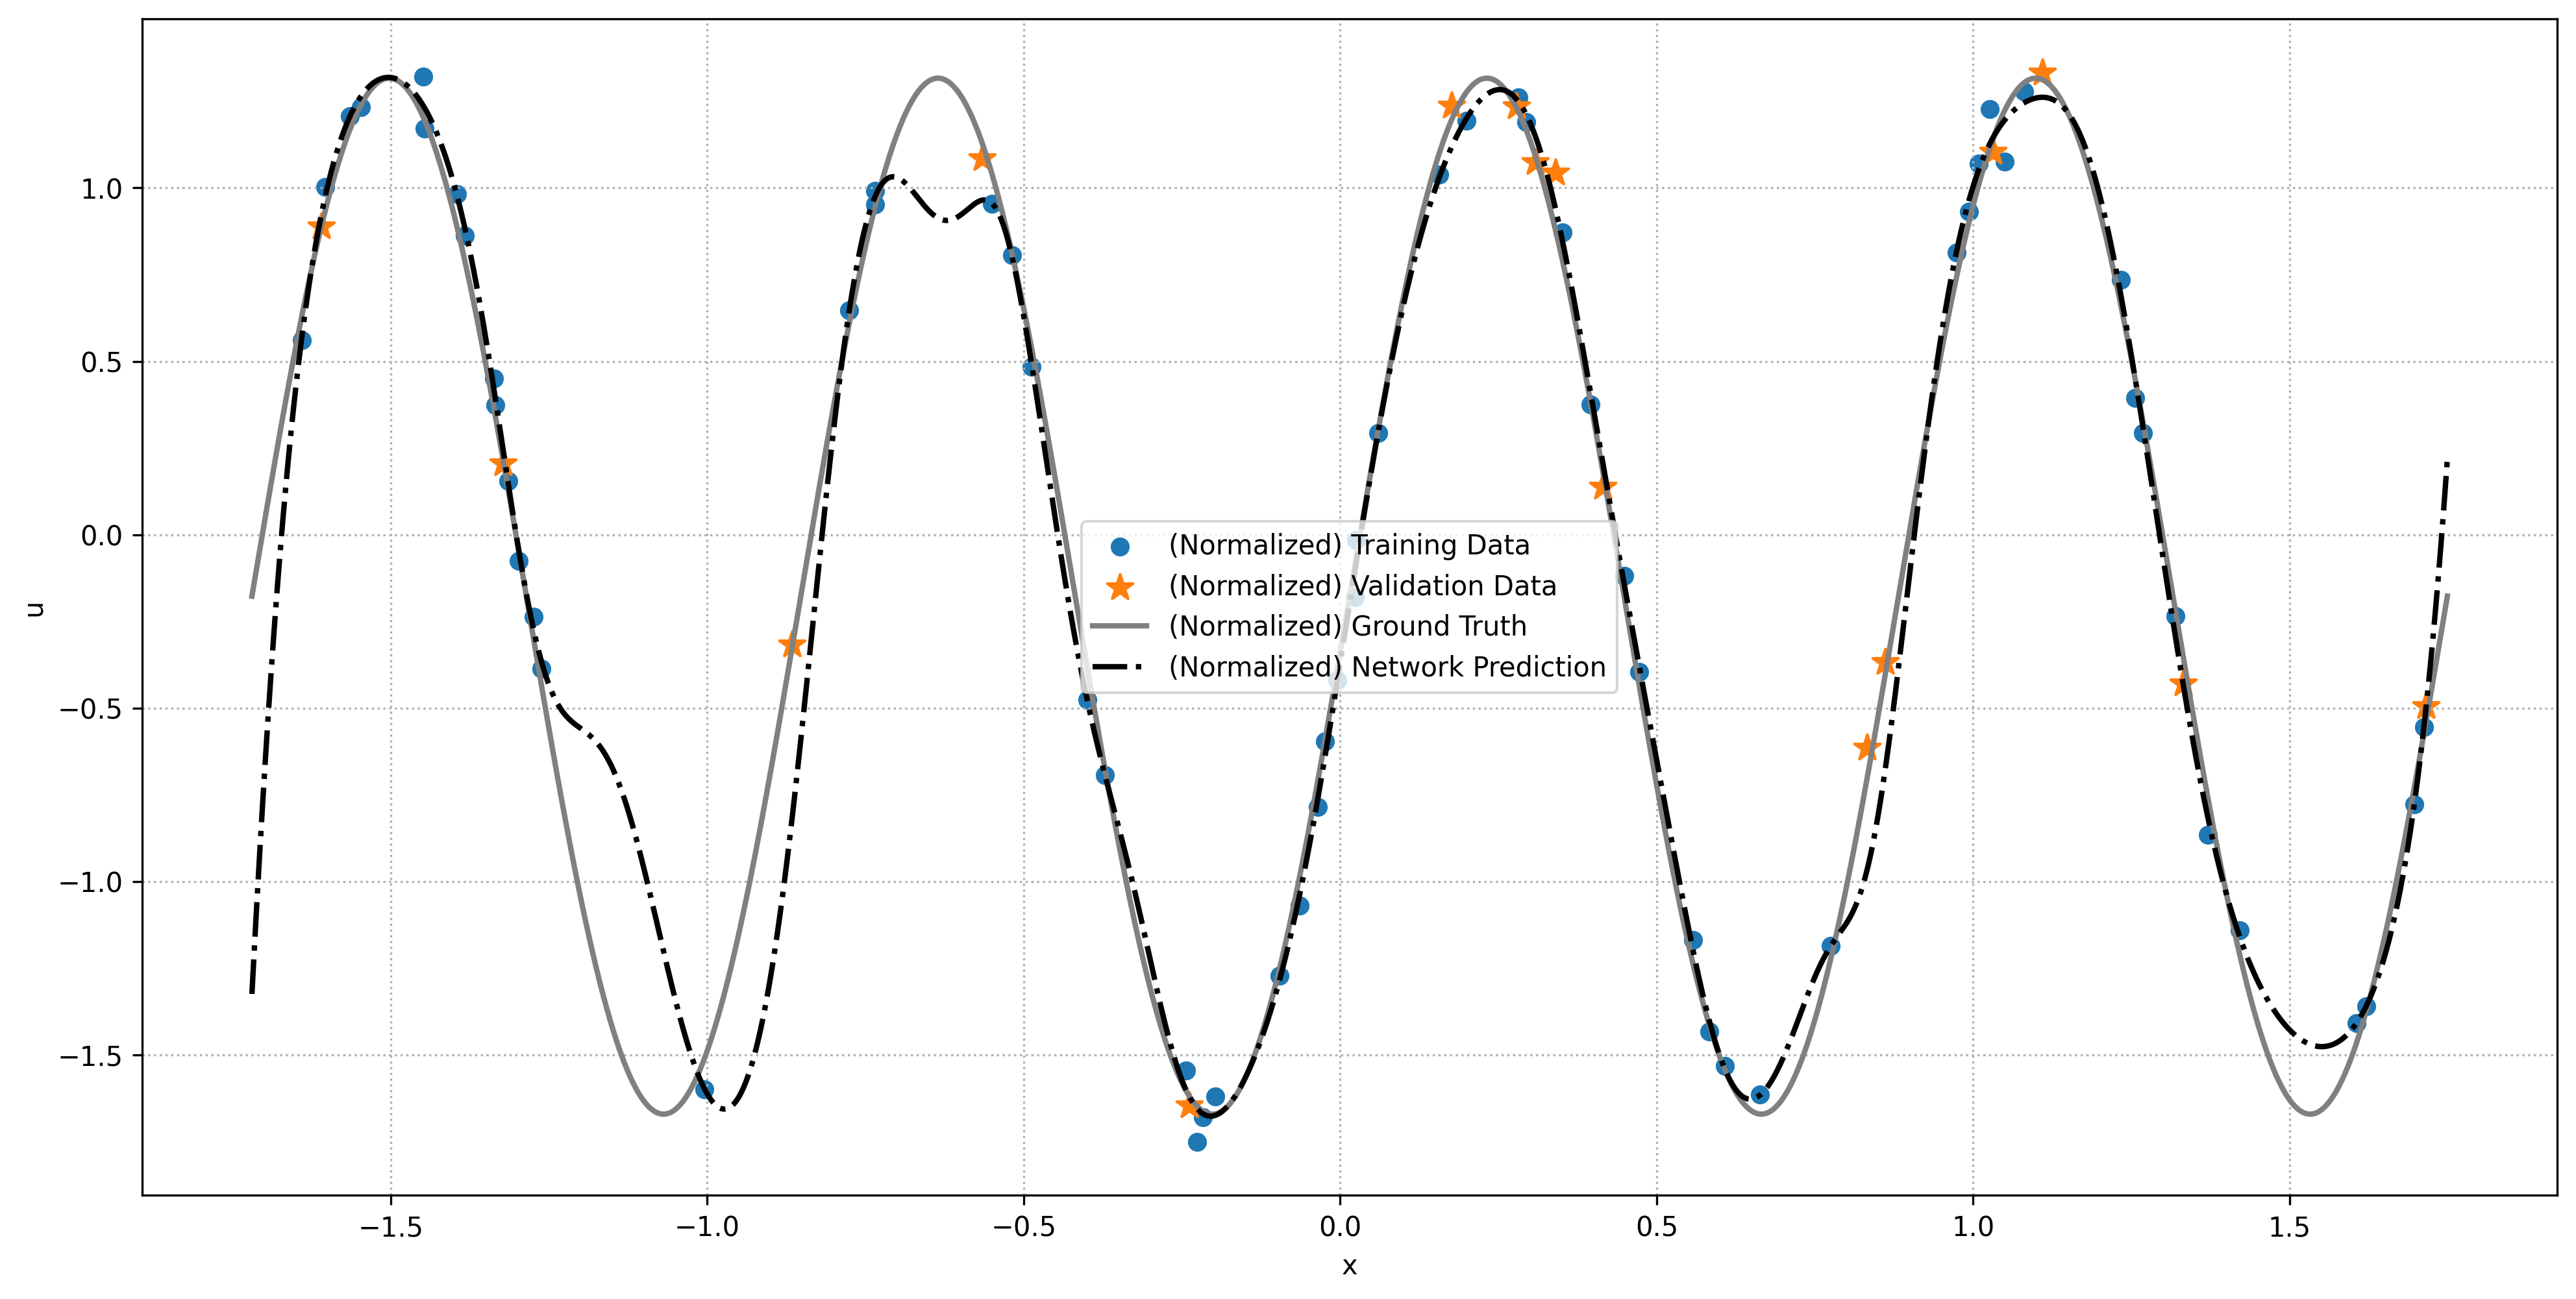

In [ ]:
plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.scatter(x_train_normalized, y_train_normalized, label="(Normalized) Training Data", marker="o", color="C0")
plt.scatter(x_val_normalized, y_val_normalized, label="(Normalized) Validation Data", marker="*", color="C1", s=100)
plt.plot(x_test_normalized, y_test_normalized, label="(Normalized) Ground Truth",lw=2, color="grey")
plt.plot(x_test_normalized, y_test_pred_normalized.detach(), label="(Normalized) Network Prediction",lw=2, color="black", ls="-.")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

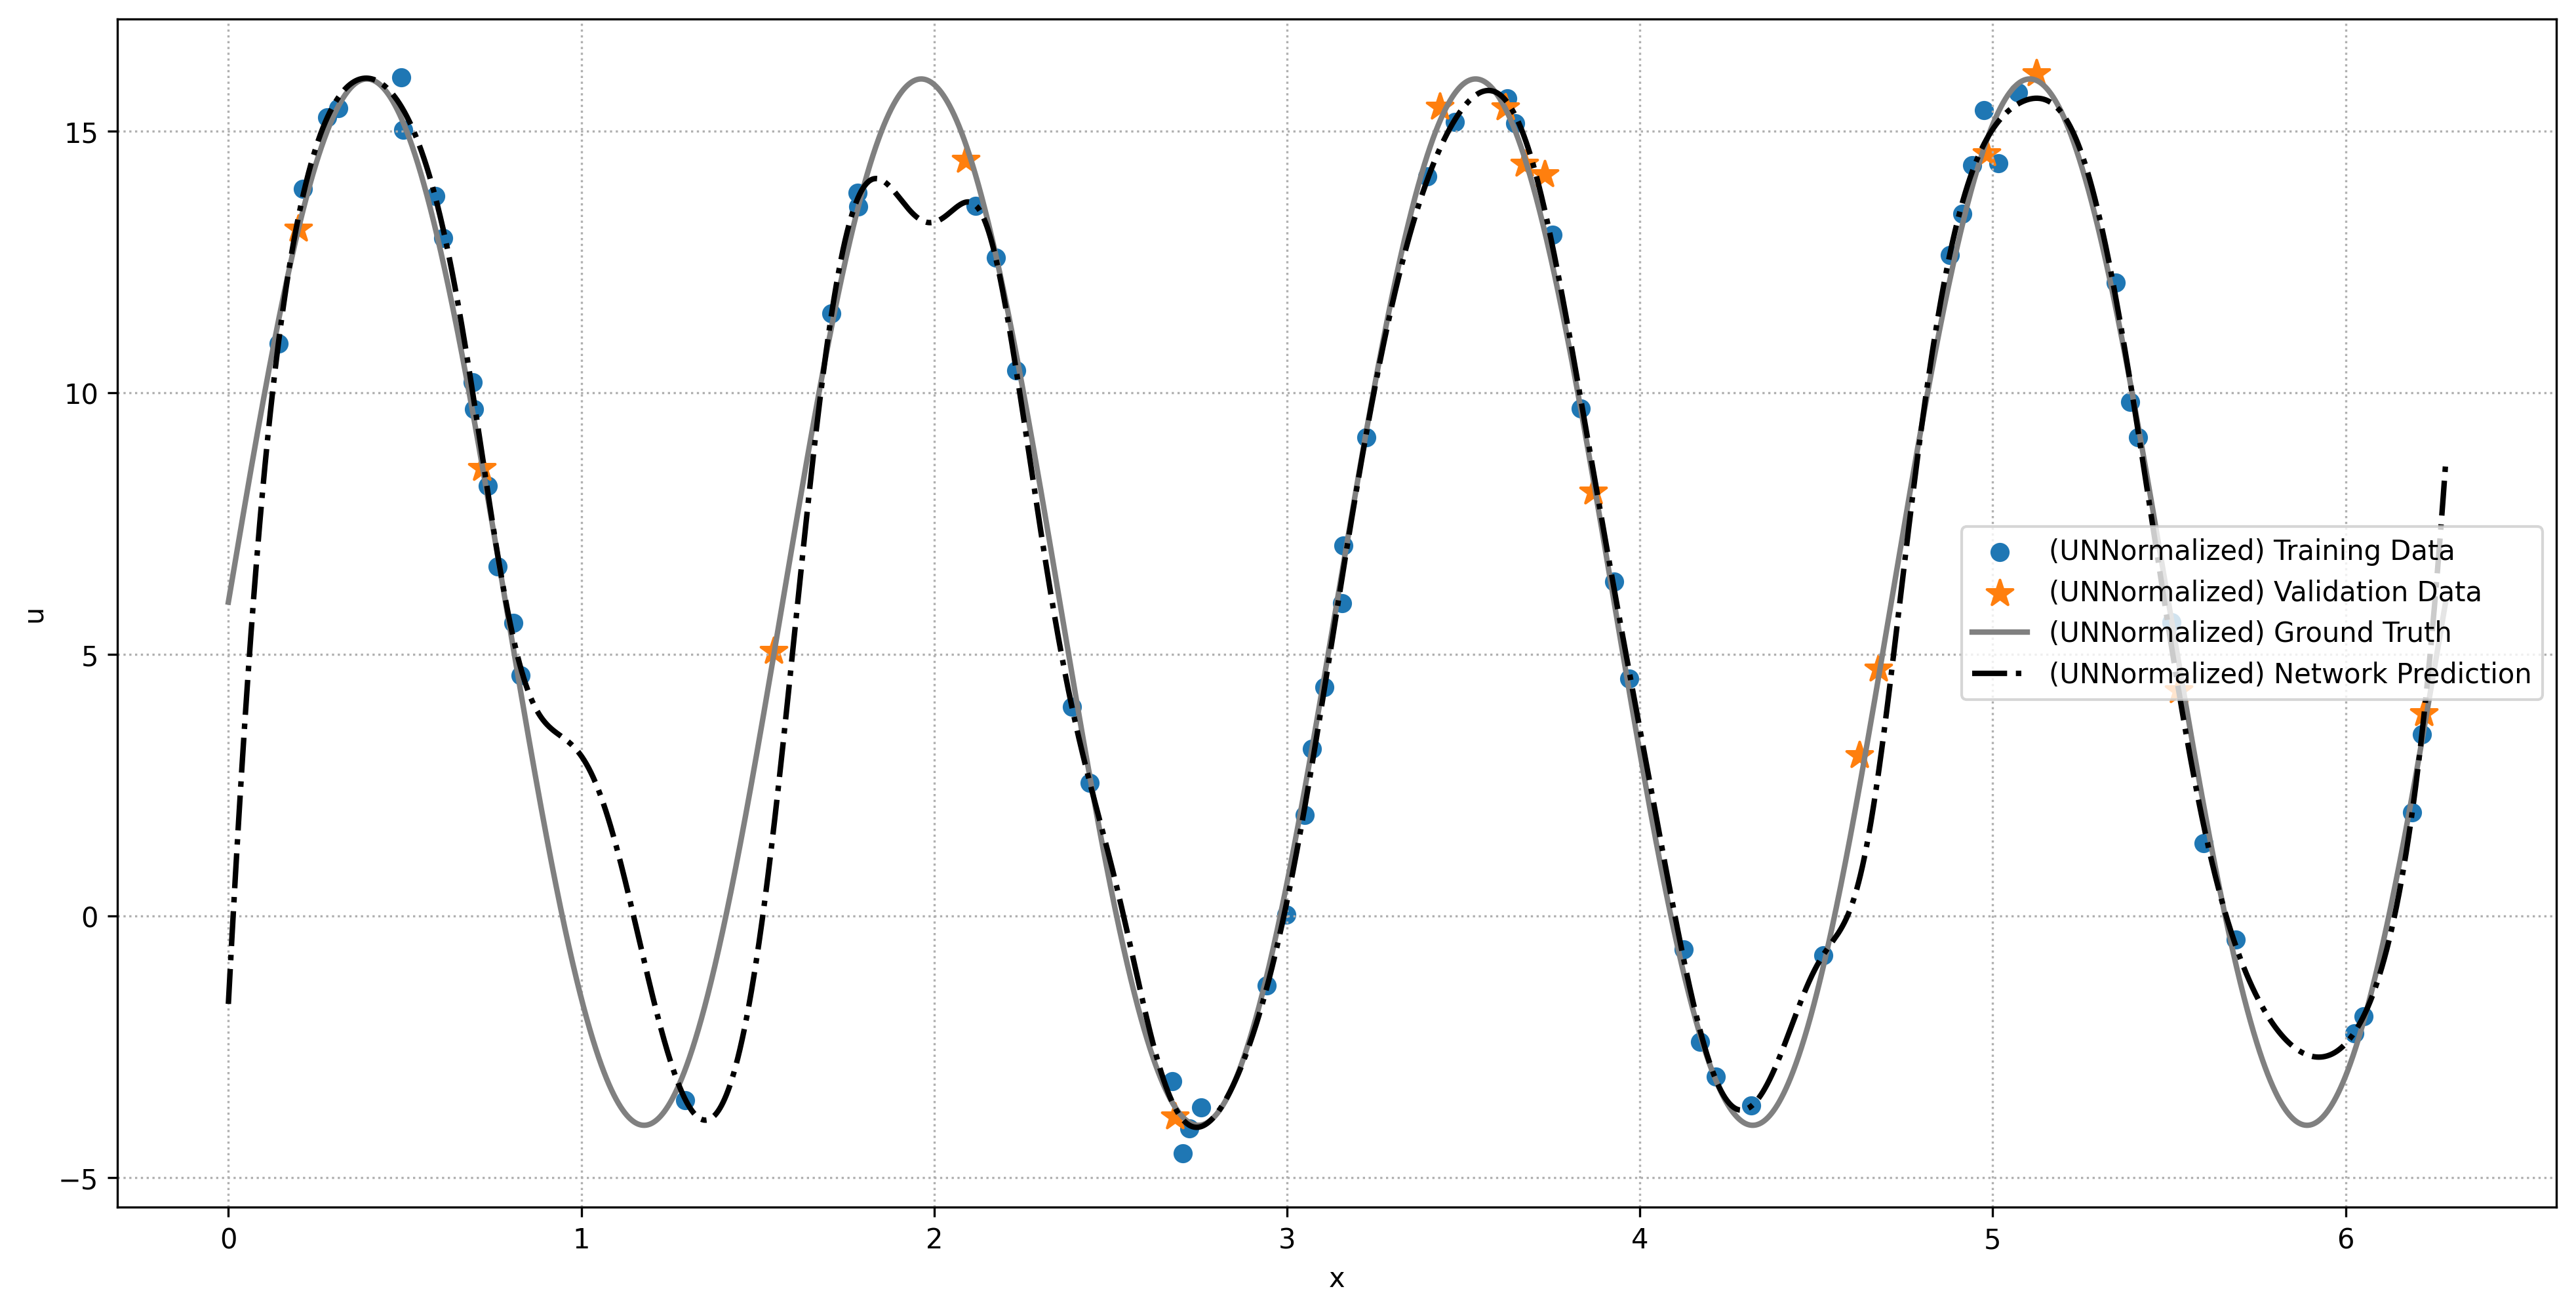

In [ ]:
plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.scatter(x_train, y_train, label="(UNNormalized) Training Data", marker="o", color="C0")
plt.scatter(x_val, y_val, label="(UNNormalized) Validation Data", marker="*", color="C1", s=100)
plt.plot(x_test, y_test, label="(UNNormalized) Ground Truth",lw=2, color="grey")
plt.plot(x_test, y_test_pred.detach(), label="(UNNormalized) Network Prediction",lw=2, color="black", ls="-.")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [ ]:
# Compute the relative validation error
relative_error_train = torch.mean((y_train_pred - y_train)**2)/torch.mean(y_train**2)
print("Relative Training Error: ", relative_error_train.detach().numpy()**0.5*100, "%")

# Compute the relative validation error
relative_error_val = torch.mean((y_val_pred - y_val)**2)/torch.mean(y_val**2)
print("Relative Validation Error: ", relative_error_val.detach().numpy()**0.5*100, "%")

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((y_test_pred - y_test)**2)/torch.mean(y_test**2)
print("Relative Testing Error: ", relative_error_test.detach().numpy()**0.5*100, "%")

Relative Training Error:  2.5893421843647957 %
Relative Validation Error:  10.926753282546997 %
Relative Testing Error:  15.735740959644318 %


## K-Fold Cross-Validation


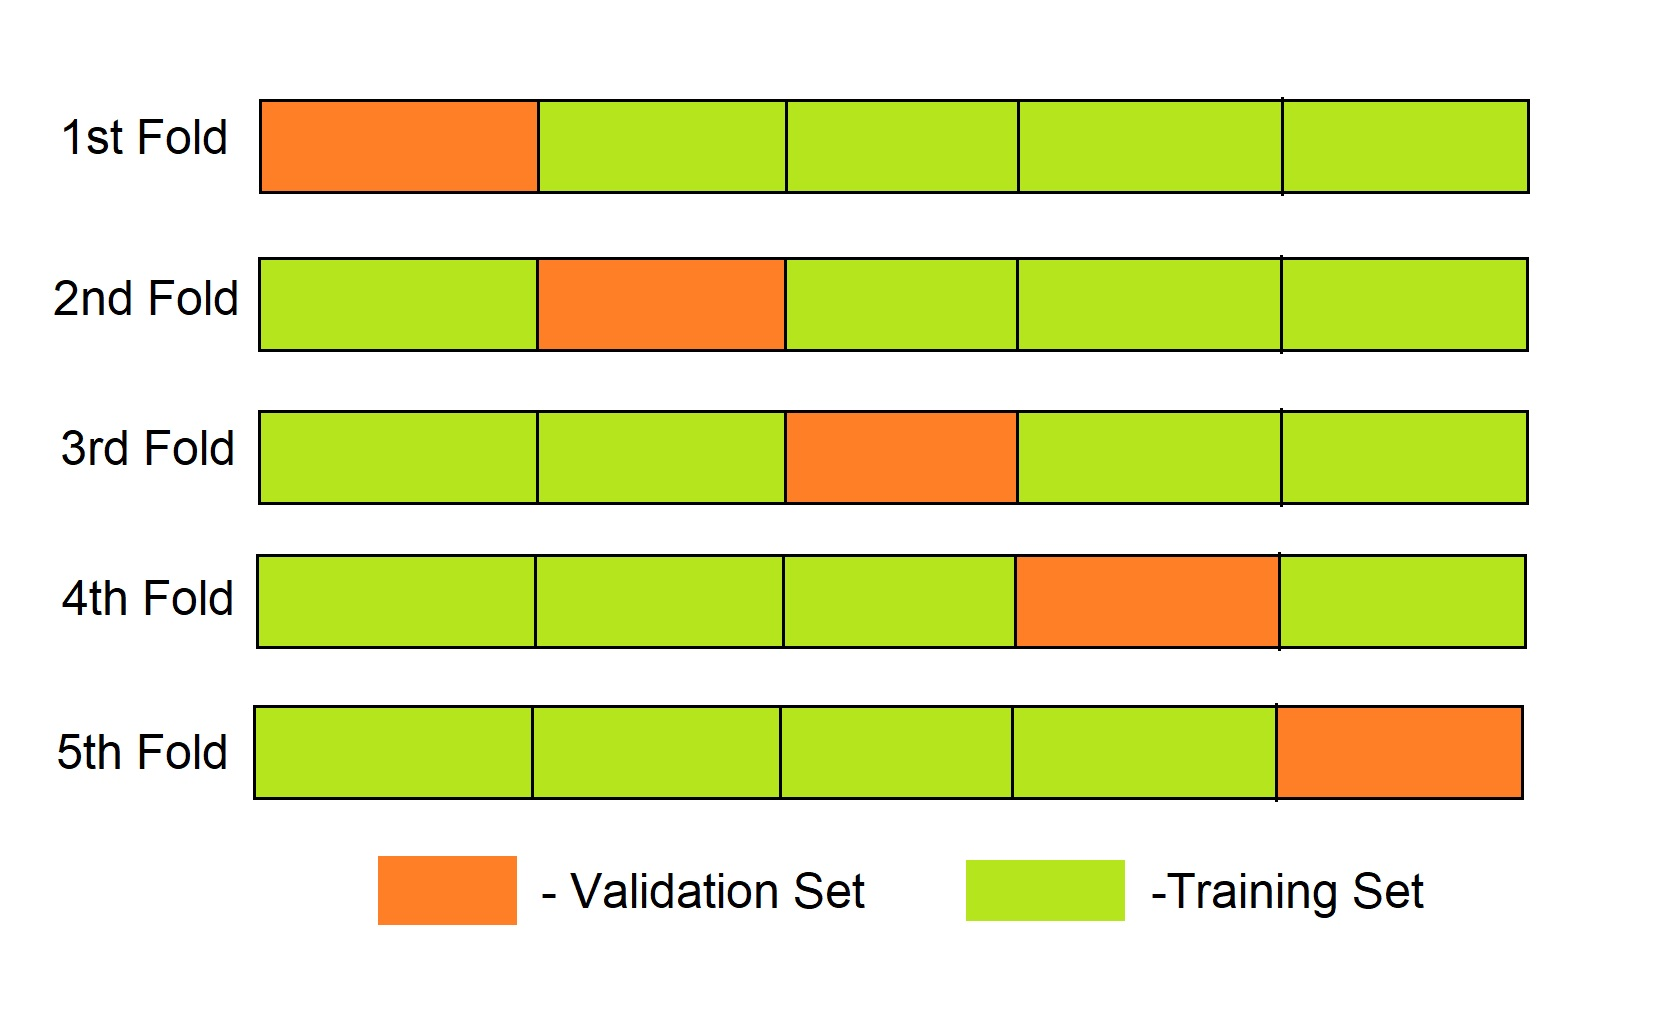

In [ ]:
kf = KFold(n_splits=10)

# remove the test data from the split
n_split = kf.get_n_splits(x)

average_train_error = 0.
average_validation_error = 0.
average_testing_error = 0.

for k, (train_index, val_index) in enumerate(kf.split(x)):
    print("#################################")
    print("Running fold number ", k)
    # Split between training and validation data
    x_train_k, x_val_k = x[train_index], x[val_index]
    y_train_k, y_val_k = y[train_index], y[val_index]
    x_train_normalized_k = normalize_x_with_training_stats(x_train_k)
    y_train_normalized_k = normalize_y_with_training_stats(y_train_k)
    x_val_normalized_k = normalize_x_with_training_stats(x_val_k)
    y_val_normalized_k = normalize_y_with_training_stats(y_val_k)

    batch_size = x_train_k.shape[0]
    
    # Define the neural network
    my_network_k = NeuralNet_Seq(
        input_dimension=x.shape[1],
        output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)
    # Random Seed for weight initialization
    retrain = 128
    # Xavier weight initialization
    init_xavier(my_network_k, retrain)
    
    
    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network_k.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network_k.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    training_set_k = DataLoader(torch.utils.data.TensorDataset(x_train_normalized_k, y_train_normalized_k), batch_size=batch_size, shuffle=True)
    
    # Train the model
    history = fit(
        my_network_k,
        training_set_k,
        x_val_normalized_k, y_val_normalized_k, n_epochs, optimizer_, p=2, verbose=False)
    
    # Compute network prediction
    y_val_pred_normalized = my_network_k(x_val_normalized_k)
    y_train_pred_normalized = my_network_k(x_train_normalized_k)
    y_test_pred_normalized = my_network(x_test_normalized)
    
    # DEnormalize preds here
    y_test_pred = denormalize_y_with_training_stats(y_test_pred_normalized)
    y_val_pred = denormalize_y_with_training_stats(y_val_pred_normalized)
    y_train_pred = denormalize_y_with_training_stats(y_train_pred_normalized)
    
    # Evaulate network performance
    relative_error_train = torch.mean((y_train_pred.reshape(-1,) - y_train_k.reshape(-1,))**2)/torch.mean(y_train.reshape(-1,)**2)
    relative_error_val = torch.mean((y_val_pred.reshape(-1,) - y_val_k.reshape(-1,))**2)/torch.mean(y_val.reshape(-1,)**2)
    relative_error_test = torch.mean((y_test_pred.reshape(-1,) - y_test.reshape(-1,))**2)/torch.mean(y_test.reshape(-1,)**2)
    
    # Compute average network performance
    average_train_error = average_train_error + relative_error_train.item()**0.5/n_split
    average_validation_error = average_validation_error +  relative_error_val.item()**0.5/n_split
    average_testing_error = average_testing_error +  relative_error_test.item()**0.5/n_split
    

#################################
Running fold number  0
Final Training Loss:  0.00080083
Final Validation Loss:  0.03750649
#################################
Running fold number  1
Final Training Loss:  0.00105012
Final Validation Loss:  0.00551699
#################################
Running fold number  2
Final Training Loss:  0.00092617
Final Validation Loss:  0.00981825
#################################
Running fold number  3
Final Training Loss:  0.00119643
Final Validation Loss:  0.0093271
#################################
Running fold number  4
Final Training Loss:  0.00111351
Final Validation Loss:  0.04776486
#################################
Running fold number  5
Final Training Loss:  0.00148088
Final Validation Loss:  0.02431916
#################################
Running fold number  6
Final Training Loss:  0.00085034
Final Validation Loss:  0.03631493
#################################
Running fold number  7
Final Training Loss:  0.00050726
Final Validation Loss:  0.01704195
#

In [ ]:
print("Relative Average Training Error: ", average_train_error*100, "%")
print("Relative Average Validation Error: ", average_validation_error*100, "%")
print("Relative Average Testing Error: ", average_testing_error*100, "%")

Relative Average Training Error:  2.1781864833441733 %
Relative Average Validation Error:  8.442380650964022 %
Relative Average Testing Error:  15.735740430012854 %


### Exercise
1. Why should one normalize the data before feeding it to the network?

2. What is the difference between the training, validation, and test data?

3. Why should we not use the test set for hyper-parameter tuning?

4. During K-Fold cross validation, what are the benefits and/or drawbacks of using a large k?

5. Perform hyper-parameter tuning using the above code (for example, selecting number of epochs, activation function, number of hidden layers, number of neurons, optimizer, learning rate, weight decay, initialization, etc?) 

6. What are the hyper-parameters that have the largest effect on the overall results?